In [2]:
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
ends = pd.read_csv("Data/Ends.csv")
games = pd.read_csv("Data/Games.csv")[['CompetitionID','SessionID','GameID','NOC1','NOC2','LSFE','Winner']]
teams = pd.read_csv("Data/Teams.csv")[['CompetitionID','TeamID','Name']]

In [4]:
ends_merged = ends.merge(games, on=['CompetitionID','SessionID','GameID'], how='left')
ends_merged = ends_merged.merge(teams, on=['CompetitionID','TeamID'], how='left')

In [5]:
report = ProfileReport(ends_merged)

In [6]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 105.06it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# Fill missing PowerPlay values and create readable labels
ends_merged['PowerPlay_clean'] = ends_merged['PowerPlay'].fillna('0').astype(str)
ends_merged['PowerPlay_label'] = ends_merged['PowerPlay_clean'].replace({
    '0': 'No PowerPlay', '1.0': 'Right Side', '2.0': 'Left Side'
})

# Sort data by game, team, and end order
ends_merged = ends_merged.sort_values(
    ['CompetitionID','SessionID','GameID','TeamID','EndID']
).reset_index(drop=True)

# PowerPlay (Left/Right) vs Result
## Compare average score and 3+ point chance by PowerPlay side

In [8]:
# Average score per PowerPlay type
pp_avg = (
    ends_merged
    .groupby('PowerPlay_label', as_index=False)['Result']
    .mean()
    .rename(columns={'Result':'AvgResult'})
)

# Probability of scoring 3 or more points
pp_3plus = (
    ends_merged
    .assign(Score3p=(ends_merged['Result']>=3).astype(int))
    .groupby('PowerPlay_label', as_index=False)['Score3p']
    .mean()
    .rename(columns={'Score3p':'P(>=3pts)'})
)

# Combine both tables into one summary
pp_summary = pp_avg.merge(pp_3plus, on='PowerPlay_label')
print("PowerPlay vs Result Summary\n", pp_summary)

PowerPlay vs Result Summary
   PowerPlay_label  AvgResult  P(>=3pts)
0       Left Side   1.568421   0.192982
1    No PowerPlay   0.933276   0.088965
2      Right Side   1.709265   0.226837


# Scoring pattern by end order (1–8)
- The reason there is EndID = 9: If two team's scores are same, extra end is considered.

In [9]:
# Scoring pattern by end order (1–8)
# Average score by EndID (overall and by PowerPlay)

# Overall average score per end
end_curve = (
    ends_merged
    .groupby('EndID', as_index=False)['Result']
    .mean()
    .rename(columns={'Result':'AvgResult'})
)

print("\nAverage score by end (overall)\n", end_curve)

# Average score per end split by PowerPlay label (pivot table)
end_curve_pp = (
    ends_merged
    .pivot_table(index='EndID', columns='PowerPlay_label', values='Result', aggfunc='mean')
    .reset_index()
)
print("\nAverage score by end (by PowerPlay)\n", end_curve_pp)


Average score by end (overall)
    EndID  AvgResult
0      1   0.845930
1      2   0.819767
2      3   0.745640
3      4   0.808140
4      5   0.838663
5      6   0.851744
6      7   1.031773
7      8   2.719917
8      9   0.606061

Average score by end (by PowerPlay)
 PowerPlay_label  EndID  Left Side  No PowerPlay  Right Side
0                    1        NaN      0.845930         NaN
1                    2   0.000000      0.820961         NaN
2                    3   1.250000      0.739970    0.714286
3                    4   0.571429      0.801815    1.384615
4                    5   1.310345      0.751227    1.666667
5                    6   1.447619      0.565217    1.610000
6                    7   1.700000      0.692308    1.644068
7                    8   2.263158      2.752998    2.851852
8                    9        NaN      0.606061         NaN


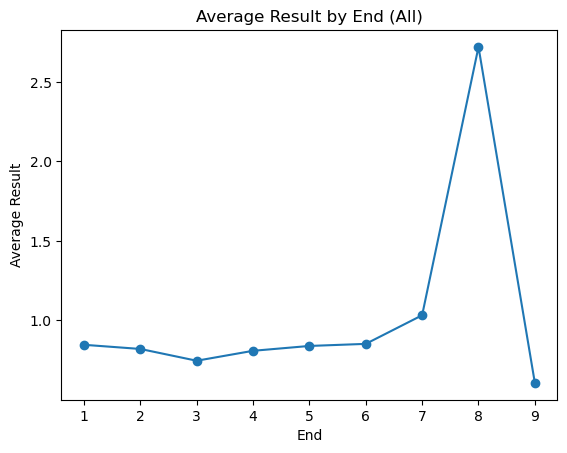

In [10]:
plt.figure()
plt.plot(end_curve['EndID'], end_curve['AvgResult'], marker='o')
plt.title('Average Result by End (All)')
plt.xlabel('End')
plt.ylabel('Average Result')
plt.xticks(range(int(end_curve['EndID'].min()), int(end_curve['EndID'].max())+1))
plt.show()

# Hammer vs Scoring Summary
## Key
LSFE from Games.csv only tells us the first-end hammer.
For later ends, the hammer switches: scoring team gives up the hammer next end;
if the end is blank (0–0), the hammer stays.
Below, we rebuild the hammer holder per end, then compare scoring with/without hammer.


In [11]:
# Merge TeamID1/TeamID2 first to make hammer tracking easier

# Re-merge: include TeamID1/TeamID2 from Games
games_full = pd.read_csv("Data/Games.csv")[['CompetitionID','SessionID','GameID','TeamID1','TeamID2','LSFE','Winner','NOC1','NOC2']]
ends_m = ends.merge(games_full, on=['CompetitionID','SessionID','GameID'], how='left')
ends_m = ends_m.merge(teams, on=['CompetitionID','TeamID'], how='left')  # 팀 이름

# Pivot to wide (rows = game-end, columns = teamID) so we can track hammer per end
wide = (
    ends_m
    .pivot_table(index=['CompetitionID','SessionID','GameID','EndID'],
                 columns='TeamID',
                 values='Result',
                 aggfunc='sum')
)

# Fill missing cells with 0 (a team column might be missing for some rows)
wide = wide.fillna(0)

# Compute hammer flags for a single game (returns a DataFrame with MultiIndex columns)
def compute_hammer_flags(game_df, team1, team2, lsfe):
    """
    game_df: index = [CompetitionID, SessionID, GameID, EndID], columns = [team1, team2] (scores for the game)
    lsfe: 1 means team1 has hammer in end 1; 0 means team2 has hammer in end 1
    Rule: scoring team gives up the hammer next end; a blank end (0-0) keeps the hammer.
    """
    ends_sorted = game_df.sort_index()

    # Promote existing score columns to a MultiIndex: (TeamID, 'Result')
    ends_sorted.columns = pd.MultiIndex.from_product([ends_sorted.columns, ['Result']])

    hammer_t1 = []
    hammer_t2 = []
    h1 = bool(lsfe == 1)   # team1 has the hammer in the first end?
    h2 = not h1

    # Access team scores using ('teamID','Result')
    for _, row in ends_sorted.iterrows():
        hammer_t1.append(int(h1))
        hammer_t2.append(int(h2))
        r1 = row[(team1, 'Result')]
        r2 = row[(team2, 'Result')]

        if (r1 == 0) and (r2 == 0):
            # Blank end: hammer stays
            pass
        elif r1 > r2:
            # team1 scored -> gives up hammer next end
            h1, h2 = False, True
        elif r2 > r1:
            # team2 scored -> gives up hammer next end
            h1, h2 = True, False
        else:
            # Safety guard (unexpected tie case)
            pass

    # Add hammer sub-columns: (teamID, 'Hammer')
    ends_sorted[(team1, 'Hammer')] = hammer_t1
    ends_sorted[(team2, 'Hammer')] = hammer_t2

    # Name the column levels for clean stacking
    ends_sorted.columns.names = ['TeamID', 'Field']
    return ends_sorted

# Loop by game: compute hammer flags, reshape to long, then tidy with pivot
long_rows = []
for (cid, sid, gid), sub in wide.groupby(level=[0,1,2]):
    # Fetch team1/team2 and LSFE for this game
    gm = games_full[
        (games_full['CompetitionID']==cid)&
        (games_full['SessionID']==sid)&
        (games_full['GameID']==gid)
    ].iloc[0]

    t1, t2, lsfe = gm['TeamID1'], gm['TeamID2'], gm['LSFE']

    # Keep only the two team columns for this game (ensure both exist)
    sub2 = sub[[t1, t2]]

    # Compute hammer flags (MultiIndex columns: (TeamID, Field))
    tagged = compute_hammer_flags(sub2, t1, t2, lsfe)

    # Use stack (not melt) to handle MultiIndex columns cleanly
    df_long = (
        tagged
        .stack(['TeamID', 'Field'])        # columns -> row levels (TeamID, Field)
        .reset_index(name='Value')         # final column named 'Value'
    )  # columns: [CompetitionID, SessionID, GameID, EndID, TeamID, Field, Value]

    # Spread 'Result' and 'Hammer' back into columns
    df_long = (
        df_long
        .pivot_table(index=['CompetitionID','SessionID','GameID','EndID','TeamID'],
                     columns='Field', values='Value', aggfunc='first')
        .reset_index()
        .rename_axis(None, axis=1)
    )

    long_rows.append(df_long)

hammer_long = pd.concat(long_rows, ignore_index=True).fillna(0)

# Clean types
hammer_long['Hammer'] = hammer_long['Hammer'].astype(int)      # 0/1
hammer_long['Result'] = hammer_long['Result'].astype(float)    # score

# Binary flag: did the team score (>0)?
hammer_long['Scored'] = (hammer_long['Result'] > 0).astype(int)

# Summary by hammer possession
hammer_summary = (
    hammer_long
    .groupby('Hammer', as_index=False)
    .agg(
        AvgResult = ('Result', 'mean'),
        P_Scored  = ('Scored', 'mean'),
        N         = ('Result', 'size')
    )
    .rename(columns={'Hammer':'HammerFlag'})
)

print("\nHammer vs Scoring Summary\n", hammer_summary)



Hammer vs Scoring Summary
    HammerFlag  AvgResult  P_Scored     N
0           0   0.607129  0.311339  2637
1           1   1.420174  0.709518  2637


# Momentum analysis (scoring flow) in later ends
- Here we look at how scoring changes by end (ΔResult)
- and use average late-end (6–8) scores as a simple momentum indicator.
- Compare team/game scoring trends across early (1–3), mid (4–5), and late (6–8) phases.

In [12]:
# Sort by team and end within each game
g = ends_merged.sort_values(['CompetitionID','SessionID','GameID','TeamID','EndID']).copy()

# Define game phase labels
def end_phase(e):
    if e <= 3: return 'Early(1-3)'
    elif e <= 5: return 'Mid(4-5)'
    else: return 'Late(6-8)'

g['Phase'] = g['EndID'].apply(end_phase)

# Average score by phase (team-game averages aggregated across all games)
phase_avg = (
    g.groupby(['Phase'])['Result']
    .mean()
    .reindex(['Early(1-3)','Mid(4-5)','Late(6-8)'])
    .reset_index(name='AvgResult')
)
print("\nAverage score by phase (early / mid / late)\n", phase_avg)

# End-to-end score change (momentum signal) = current score − previous end score
g['PrevResult'] = g.groupby(['CompetitionID','SessionID','GameID','TeamID'])['Result'].shift(1)
g['DeltaResult'] = g['Result'] - g['PrevResult']

momentum_signal = (
    g.groupby('EndID')['DeltaResult']
    .mean()
    .reset_index(name='AvgDelta')
)
print("\nAverage score change per end (momentum signal)\n", momentum_signal)

# (Optional) Show score trend for one sample game/team
sample = g[
    (g['CompetitionID']==g['CompetitionID'].iloc[0]) &
    (g['SessionID']==g['SessionID'].iloc[0]) &
    (g['GameID']==g['GameID'].iloc[0])
][['TeamID','EndID','Result']]
print("\nSample game score trend by team\n", sample.sort_values(['TeamID','EndID']).head(16))


Average score by phase (early / mid / late)
         Phase  AvgResult
0  Early(1-3)   0.803779
1    Mid(4-5)   0.823401
2   Late(6-8)   1.392585

Average score change per end (momentum signal)
    EndID  AvgDelta
0      1       NaN
1      2 -0.026163
2      3 -0.074128
3      4  0.062500
4      5  0.030523
5      6  0.013081
6      7  0.187291
7      8  1.842324
8      9 -0.121212

Sample game score trend by team
     TeamID  EndID  Result
0       19      1       0
1       19      2       2
2       19      3       0
3       19      4       1
4       19      5       2
5       19      6       0
6       19      7       0
7       19      8       0
8       27      1       1
9       27      2       0
10      27      3       3
11      27      4       0
12      27      5       0
13      27      6       1
14      27      7       3
15      27      8       1


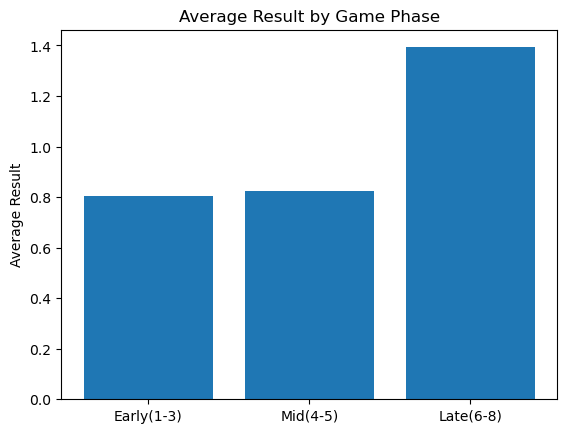

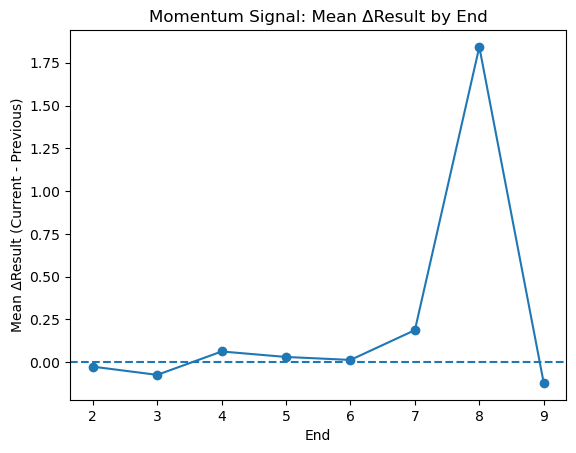

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(phase_avg['Phase'], phase_avg['AvgResult'])
plt.title('Average Result by Game Phase')
plt.ylabel('Average Result')
plt.show()

plt.figure()
plt.plot(momentum_signal['EndID'], momentum_signal['AvgDelta'], marker='o')
plt.title('Momentum Signal: Mean ΔResult by End')
plt.xlabel('End')
plt.ylabel('Mean ΔResult (Current - Previous)')
plt.axhline(0, linestyle='--')
plt.show()

# PowerPlay usage by End

PowerPlay usage by End
    EndID  Count  UsageRate(%)
0      2      1          0.15
1      3     15          2.18
2      4     27          3.92
3      5     77         11.19
4      6    205         29.80
5      7    208         30.23
6      8     65          9.45


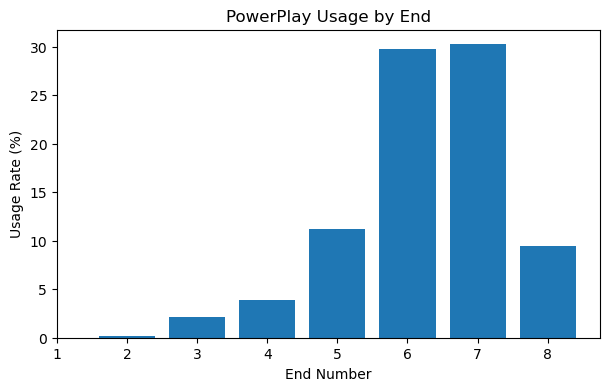

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Clean PowerPlay data
ends_merged['PowerPlay_clean'] = ends_merged['PowerPlay'].fillna(0).astype(int)

# Keep only the ends where PowerPlay was used
pp_used = ends_merged[ends_merged['PowerPlay_clean'] > 0]

# Count how many times PowerPlay was used in each end
pp_by_end = (
    pp_used.groupby('EndID')
    .size()
    .reset_index(name='Count')
)

# Calculate usage rate (%) out of total number of games
total_games = ends_merged[['CompetitionID','SessionID','GameID','TeamID']].drop_duplicates().shape[0]
pp_by_end['UsageRate(%)'] = (pp_by_end['Count'] / total_games * 100).round(2)

print("PowerPlay usage by End\n", pp_by_end)

# Visualize PowerPlay usage frequency by end
plt.figure(figsize=(7,4))
plt.bar(pp_by_end['EndID'], pp_by_end['UsageRate(%)'])
plt.title("PowerPlay Usage by End")
plt.xlabel("End Number")
plt.ylabel("Usage Rate (%)")
plt.xticks(range(1, int(pp_by_end['EndID'].max())+1))
plt.show()


# Teams that never used PowerPlay

In [15]:
# Fill missing PowerPlay values (0 = not used)
ends_merged['PowerPlay_clean'] = ends_merged['PowerPlay'].fillna(0).astype(int)

# For each team, check if they used PowerPlay at least once
pp_usage = (
    ends_merged
    .groupby('TeamID')['PowerPlay_clean']
    .apply(lambda x: (x > 0).any())   # True if any PowerPlay used
    .reset_index(name='UsedPowerPlay')
)

# Merge team names for easier reading
pp_usage = pp_usage.merge(
    teams[['CompetitionID','TeamID','Name']],
    on='TeamID',
    how='left'
).drop_duplicates('TeamID')

# Find teams that never used PowerPlay
no_pp_teams = pp_usage[pp_usage['UsedPowerPlay'] == False]

print("Teams that never used PowerPlay:")
print(no_pp_teams[['TeamID','Name']])
print(f"\nTotal teams that never used PowerPlay: {len(no_pp_teams)}")

Teams that never used PowerPlay:
Empty DataFrame
Columns: [TeamID, Name]
Index: []

Total teams that never used PowerPlay: 0


# Win rate when PowerPlay is used, by End

📊 Win rate when PowerPlay is used, by End:
   EndID   WinRate  Uses
6      8  0.676923    65
5      7  0.586538   208
4      6  0.390244   205
3      5  0.155844    77
1      3  0.066667    15
2      4  0.000000    27
0      2  0.000000     1

📊 Win rate by End × PowerPlay side (Right/Left):
    EndID PowerPlay_label   WinRate  Uses
0       2            Left  0.000000     1
1       3            Left  0.125000     8
2       3           Right  0.000000     7
3       4            Left  0.000000    14
4       4           Right  0.000000    13
5       5            Left  0.137931    29
6       5           Right  0.166667    48
7       6            Left  0.409524   105
8       6           Right  0.370000   100
9       7            Left  0.611111    90
10      7           Right  0.567797   118
11      8            Left  0.684211    38
12      8           Right  0.666667    27


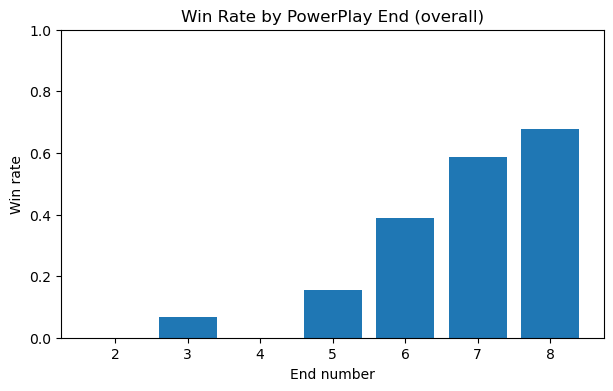

In [16]:
# --- 0) Basic cleaning -------------------------------------------------------
# Fill missing PowerPlay (0 = not used). Also make a readable label.
ends_m['PowerPlay_clean'] = ends_m['PowerPlay'].fillna(0).astype(int)
ends_m['PowerPlay_label'] = ends_m['PowerPlay_clean'].replace(
    {0:'No PowerPlay', 1.0:'Right', 2.0:'Left'}
)

# Some rows may have missing 'Winner' (e.g., incomplete games) → drop them
em = ends_m.dropna(subset=['Winner', 'TeamID', 'EndID']).copy()

# --- 1) Win flag per team-row -----------------------------------------------
# WinFlag = 1 if this row's team won the game, else 0
em['WinFlag'] = np.where(
    ((em['TeamID'] == em['TeamID1']) & (em['Winner'] == 1)) |
    ((em['TeamID'] == em['TeamID2']) & (em['Winner'] == 0)),
    1, 0
)

# Keep only ends where PowerPlay was used (1=Right, 2=Left)
pp_used = em[em['PowerPlay_clean'] > 0].copy()

# --- 2) Win rate by EndID (overall, regardless of side) ----------------------
pp_winrate = (
    pp_used
    .groupby('EndID', as_index=False)
    .agg(
        WinRate=('WinFlag', 'mean'),
        Uses=('WinFlag', 'size')  # how many PowerPlays used at that end
    )
    .sort_values(['WinRate', 'Uses'], ascending=[False, False])
)

print("📊 Win rate when PowerPlay is used, by End:")
print(pp_winrate)

# --- 3) (Optional) Split by side: Right vs Left ------------------------------
pp_winrate_side = (
    pp_used
    .groupby(['EndID','PowerPlay_label'], as_index=False)
    .agg(
        WinRate=('WinFlag','mean'),
        Uses=('WinFlag','size')
    )
    .sort_values(['EndID','PowerPlay_label'])
)

print("\n📊 Win rate by End × PowerPlay side (Right/Left):")
print(pp_winrate_side)

# --- 4) (Optional) Quick bar chart ------------------------------------------
plt.figure(figsize=(7,4))
plt.bar(pp_winrate['EndID'], pp_winrate['WinRate'])
plt.title("Win Rate by PowerPlay End (overall)")
plt.xlabel("End number")
plt.ylabel("Win rate")
plt.xticks(range(int(pp_winrate['EndID'].min()), int(pp_winrate['EndID'].max())+1))
plt.ylim(0, 1)
plt.show()

# Comeback rate (after 8th-end PowerPlay)

In [17]:
# Make sure ends_merged has: CompetitionID, SessionID, GameID, EndID, TeamID, Result, PowerPlay, TeamID1, TeamID2, Winner
em = ends_m.copy()

# 1️⃣ Clean PowerPlay column (0 = not used, 1 = right, 2 = left)
em['PowerPlay_clean'] = em['PowerPlay'].fillna(0).astype(int)

# 2️⃣ Sort rows by game and end order
em = em.sort_values(['CompetitionID','SessionID','GameID','TeamID','EndID'])

# 3️⃣ Calculate each team's total score before this end (previous ends only)
em['CumBefore'] = em.groupby(
    ['CompetitionID','SessionID','GameID','TeamID']
)['Result'].cumsum().shift(1).fillna(0)

# 4️⃣ Calculate total cumulative score up to this end
em['CumAfter'] = em.groupby(
    ['CompetitionID','SessionID','GameID','TeamID']
)['Result'].cumsum()

# 5️⃣ Focus only on the 8th end
e8 = em[em['EndID'] == 8].copy()

# 6️⃣ Compute opponent's score before and after the 8th end
sum_before = e8.groupby(['CompetitionID','SessionID','GameID'])['CumBefore'].transform('sum')
sum_after  = e8.groupby(['CompetitionID','SessionID','GameID'])['CumAfter'].transform('sum')

e8['OppBefore'] = sum_before - e8['CumBefore']
e8['OppAfter']  = sum_after  - e8['CumAfter']

# 7️⃣ Select teams that used PowerPlay and were losing before the 8th end
mask_pp_trailing = (e8['PowerPlay_clean'] > 0) & (e8['CumBefore'] <= e8['OppBefore'])
cand = e8[mask_pp_trailing].copy()

# 8️⃣ Check if they took the lead (come back) after the 8th end
cand['Cameback'] = (cand['CumAfter'] > cand['OppAfter']).astype(int)

# 9️⃣ Calculate comeback rate (regardless of final win)
if len(cand) > 0:
    comeback_rate = cand['Cameback'].mean()
else:
    comeback_rate = np.nan

print(f"Number of samples (8th-end PP used while trailing): {len(cand)}")
print(f"Comeback rate (after 8th-end PowerPlay): {comeback_rate:.3f}")

# 10️⃣ Optional: check average score gap and PowerPlay side
if len(cand) > 0:
    cand['PP_side'] = cand['PowerPlay_clean'].map({1:'Right', 2:'Left'})
    avg_gap = (cand['OppBefore'] - cand['CumBefore']).mean()
    by_side = cand.groupby('PP_side')['Cameback'].mean().reset_index(name='ComebackRate')
    print(f"\nAverage score gap before 8th end: {avg_gap:.2f}")
    print("\nComeback rate by PowerPlay side:")
    print(by_side)

Number of samples (8th-end PP used while trailing): 36
Comeback rate (after 8th-end PowerPlay): 0.389

Average score gap before 8th end: 1.19

Comeback rate by PowerPlay side:
  PP_side  ComebackRate
0    Left        0.3500
1   Right        0.4375


# Loss rate when using PowerPlay

In [18]:
em = ends_m.copy()

# 1️⃣ Clean PowerPlay values (0 = not used, 1 = right, 2 = left)
em['PowerPlay_clean'] = em['PowerPlay'].fillna(0).astype(int)

# 2️⃣ Calculate opponent’s score
#    Opponent score = total end score - team’s own score
em = em.sort_values(['CompetitionID','SessionID','GameID','EndID','TeamID'])
sum_end = em.groupby(['CompetitionID','SessionID','GameID','EndID'])['Result'].transform('sum')
em['OppResult'] = sum_end - em['Result']

# 3️⃣ Keep only the rows where PowerPlay was used
pp = em[em['PowerPlay_clean'] > 0].copy()

# 4️⃣ Check if the team lost points (scored less than the opponent)
pp['PointDiff'] = pp['Result'] - pp['OppResult']  # team score - opponent score
pp['LostPointsFlag'] = (pp['PointDiff'] < 0).astype(int)

# 5️⃣ Calculate overall loss rate
overall_rate = pp['LostPointsFlag'].mean()
n_pp = len(pp)

print(f"Number of ends with PowerPlay: {n_pp}")
print(f"Loss rate when using PowerPlay: {overall_rate:.3f}")

# 6️⃣ (Optional) Loss rate by end number
by_end = (
    pp.groupby('EndID')['LostPointsFlag']
      .mean()
      .reset_index(name='P_LostPoints')
      .sort_values('EndID')
)
print("\nLoss rate by end number")
print(by_end)

# 7️⃣ (Optional) Loss rate by PowerPlay side (Right or Left)
pp['PP_side'] = pp['PowerPlay_clean'].map({1:'Right', 2:'Left'})
by_side = (
    pp.groupby('PP_side')['LostPointsFlag']
      .mean()
      .reset_index(name='P_LostPoints')
      .sort_values('P_LostPoints', ascending=False)
)
print("\nLoss rate by PowerPlay side")
print(by_side)

# 8️⃣ (Optional) Extra stats: blank ends (0-0) and giving up ≥1 point
pp['BlankEndFlag'] = ((pp['Result'] == 0) & (pp['OppResult'] == 0)).astype(int)
pp['GaveUpAny'] = (pp['OppResult'] > 0).astype(int)

print(f"\nBlank-end rate (PowerPlay used): {pp['BlankEndFlag'].mean():.3f}")
print(f"Rate of giving up at least 1 point: {pp['GaveUpAny'].mean():.3f}")

Number of ends with PowerPlay: 598
Loss rate when using PowerPlay: 0.202

Loss rate by end number
   EndID  P_LostPoints
0      2      1.000000
1      3      0.333333
2      4      0.296296
3      5      0.207792
4      6      0.200000
5      7      0.177885
6      8      0.200000

Loss rate by PowerPlay side
  PP_side  P_LostPoints
0    Left      0.228070
1   Right      0.178914

Blank-end rate (PowerPlay used): 0.003
Rate of giving up at least 1 point: 0.221


# Loss rate when not using PowerPlay

In [19]:
em = ends_m.copy()

# 1️⃣ Fill missing PowerPlay values (0 = not used)
em['PowerPlay_clean'] = em['PowerPlay'].fillna(0).astype(int)

# 2️⃣ Calculate opponent’s score in each game and end
sum_end = em.groupby(['CompetitionID','SessionID','GameID','EndID'])['Result'].transform('sum')
em['OppResult'] = sum_end - em['Result']

# 3️⃣ Identify which team has the hammer
# LSFE: 1 = TeamID1 had the hammer first, 0 = TeamID2 had it first
# (Note: in real games the hammer changes every end, but this is a simple version)
em['HasHammer'] = np.where(
    ((em['LSFE'] == 1) & (em['TeamID'] == em['TeamID1'])) |
    ((em['LSFE'] == 0) & (em['TeamID'] == em['TeamID2'])),
    1, 0
)

# 4️⃣ Keep only rows where the team had the hammer and did not use PowerPlay
no_pp_hammer = em[(em['HasHammer'] == 1) & (em['PowerPlay_clean'] == 0)].copy()

# 5️⃣ Check if the team lost points (opponent scored more)
no_pp_hammer['LostPointsFlag'] = (no_pp_hammer['Result'] < no_pp_hammer['OppResult']).astype(int)

# 6️⃣ Calculate overall loss rate
loss_rate = no_pp_hammer['LostPointsFlag'].mean()
n = len(no_pp_hammer)

print(f"Number of ends with hammer & no PowerPlay: {n}")
print(f"Loss rate (opponent scored more): {loss_rate:.3f}")

# 7️⃣ (Optional) Compare loss rate by end number
by_end = (
    no_pp_hammer.groupby('EndID')['LostPointsFlag']
    .mean()
    .reset_index(name='P_LostPoints')
    .sort_values('EndID')
)

print("\nLoss rate by end (Hammer & No PowerPlay)")
print(by_end)

Number of ends with hammer & no PowerPlay: 2352
Loss rate (opponent scored more): 0.493

Loss rate by end (Hammer & No PowerPlay)
   EndID  P_LostPoints
0      1      0.311047
1      2      0.543605
2      3      0.432749
3      4      0.531157
4      5      0.506289
5      6      0.651452
6      7      0.633880
7      8      0.414286
8      9      0.545455


# Win Rate of Hammer Teams Across All Ends

In [20]:
# For each end, find which team had the hammer and which team won
end_results = (
    hammer_long.groupby(['CompetitionID', 'SessionID', 'GameID', 'EndID'])
    .apply(lambda x: pd.Series({
        'HammerTeam': x.loc[x['Hammer'] == 1, 'TeamID'].iloc[0],  # team with hammer in this end
        'MaxScore': x['Result'].max(),                            # highest score in this end
        'WinningTeam': x.loc[x['Result'].idxmax(), 'TeamID']      # team that scored the most
    }))
    .reset_index()
)

# Check if the hammer team won this end
end_results['HammerWinFlag'] = (end_results['HammerTeam'] == end_results['WinningTeam']).astype(int)

# Calculate the win rate of hammer teams across all ends
hammer_end_win_rate = end_results['HammerWinFlag'].mean()
print(f"🔹 Hammer team win rate per end: {hammer_end_win_rate:.3f}")

🔹 Hammer team win rate per end: 0.700


# Number of games where different teams used PowerPlay in 7th and 8th ends

In [26]:
em = ends_m.copy()

# 1️⃣ Clean PowerPlay column (0 = not used, 1 = right side, 2 = left side)
em['PowerPlay_clean'] = em['PowerPlay'].fillna(0).astype(int)

# 2️⃣ Keep only the ends where PowerPlay was used
pp_used = em[em['PowerPlay_clean'] > 0]

# 3️⃣ Find teams that used PowerPlay in the 7th or 8th end
pp_7 = pp_used[pp_used['EndID'] == 7][['CompetitionID', 'SessionID', 'GameID', 'TeamID']].rename(columns={'TeamID': 'PP7_Team'})
pp_8 = pp_used[pp_used['EndID'] == 8][['CompetitionID', 'SessionID', 'GameID', 'TeamID']].rename(columns={'TeamID': 'PP8_Team'})

# 4️⃣ Merge both by game ID to find games where PowerPlay was used in both 7th and 8th ends
pp_both = pd.merge(pp_7, pp_8, on=['CompetitionID', 'SessionID', 'GameID'], how='inner')

# 5️⃣ Keep only games where different teams used PowerPlay (one in 7th, the other in 8th)
pp_opposite = pp_both[pp_both['PP7_Team'] != pp_both['PP8_Team']].copy()

# 6️⃣ Count the number of such games and calculate their ratio
num_games_with_pp = len(pp_opposite)
unique_games = em[['CompetitionID', 'SessionID', 'GameID']].drop_duplicates()
total_games = len(unique_games)

ratio = num_games_with_pp / total_games * 100

print(f"Number of games where different teams used PowerPlay in 7th and 8th ends: {num_games_with_pp}")
print(f"Total number of games: {total_games}")
print(f"Ratio: {ratio:.2f}%")

print("\nSample game list:")
print(pp_opposite.head())


Number of games where different teams used PowerPlay in 7th and 8th ends: 36
Total number of games: 344
Ratio: 10.47%

Sample game list:
   CompetitionID  SessionID  GameID  PP7_Team  PP8_Team
0              0          4       1        17        10
1              0         12       3        20        18
2              0         13       2        10        24
3       22230015          1       2        46        25
4       22230015          2       2        34        17


# Average score difference at the end of games

In [27]:
# Load game data
games = pd.read_csv("Data/Games.csv")[['CompetitionID', 'SessionID', 'GameID', 'ResultStr1', 'ResultStr2']]

# 1️⃣ Convert score columns to numeric values
games['ResultStr1'] = pd.to_numeric(games['ResultStr1'], errors='coerce')
games['ResultStr2'] = pd.to_numeric(games['ResultStr2'], errors='coerce')

# 2️⃣ Calculate score difference (absolute value)
games['ScoreDiff'] = (games['ResultStr1'] - games['ResultStr2']).abs()

# 3️⃣ Calculate the average score difference
avg_diff = games['ScoreDiff'].mean()

print(f"🏁 Average score difference at the end of games: {avg_diff:.2f} points")

# (Optional) Show summary statistics of score differences
print("\n📊 Summary of score difference:")
print(games['ScoreDiff'].describe())

🏁 Average score difference at the end of games: 3.55 points

📊 Summary of score difference:
count    344.000000
mean       3.546512
std        2.238841
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       11.000000
Name: ScoreDiff, dtype: float64


🏆 Hammer Win Rate by PowerPlay Status
   PowerPlay_clean  HammerWinRate  Count              PP_label
0                0       0.675331   2039          No PowerPlay
1                1       0.811502    313  Right Side PowerPlay
2                2       0.757895    285   Left Side PowerPlay


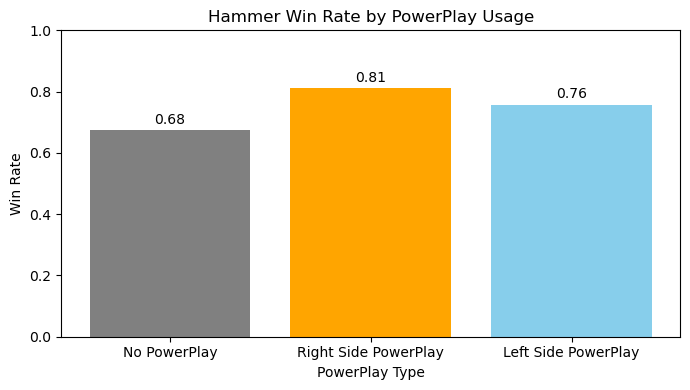

In [23]:
# 1️⃣ 데이터 준비 --------------------------------------------------
# 타입 맞추기 (merge가 정확히 되도록)
for col in ['CompetitionID','SessionID','GameID','EndID']:
    hammer_long[col] = hammer_long[col].astype(int)
    ends_m[col] = ends_m[col].astype(int)

# PowerPlay 정보만 추출
pp_info = ends_m[['CompetitionID','SessionID','GameID','EndID','PowerPlay']].copy()
pp_info['PowerPlay_clean'] = pp_info['PowerPlay'].fillna(0).astype(int)

# hammer_long과 merge
hl = hammer_long.merge(pp_info, on=['CompetitionID','SessionID','GameID','EndID'], how='left')

# PowerPlay 라벨 붙이기
hl['PP_label'] = hl['PowerPlay_clean'].map({0:'No PowerPlay', 1:'Right Side', 2:'Left Side'})

# 2️⃣ 각 엔드별 승자 & 해머 팀 판별 ----------------------------------
end_results = (
    hl.groupby(['CompetitionID','SessionID','GameID','EndID'])
    .apply(lambda x: pd.Series({
        'HammerTeam': x.loc[x['Hammer']==1,'TeamID'].iloc[0],
        'WinningTeam': x.loc[x['Result'].idxmax(),'TeamID'],
        'PowerPlay_clean': x['PowerPlay_clean'].max()   # 그 엔드의 PowerPlay 상태 (0,1,2)
    }))
    .reset_index()
)

# 해머 팀이 이겼는가?
end_results['HammerWinFlag'] = (end_results['HammerTeam'] == end_results['WinningTeam']).astype(int)

# 3️⃣ PowerPlay 상태별 해머 승률 계산 --------------------------------
summary = (
    end_results
    .groupby('PowerPlay_clean')
    .agg(
        HammerWinRate=('HammerWinFlag','mean'),
        Count=('HammerWinFlag','size')
    )
    .reset_index()
)

# 라벨링
summary['PP_label'] = summary['PowerPlay_clean'].map({
    0: 'No PowerPlay',
    1: 'Right Side PowerPlay',
    2: 'Left Side PowerPlay'
})

print("🏆 Hammer Win Rate by PowerPlay Status")
print(summary)

# 4️⃣ 시각화 --------------------------------------------------------
plt.figure(figsize=(7,4))
plt.bar(summary['PP_label'], summary['HammerWinRate'], color=['gray','orange','skyblue'])
plt.title('Hammer Win Rate by PowerPlay Usage')
plt.ylabel('Win Rate')
plt.xlabel('PowerPlay Type')
plt.ylim(0, 1)
for i, v in enumerate(summary['HammerWinRate']):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

In [24]:
print(em['PowerPlay_clean'].value_counts())


PowerPlay_clean
0    4676
1     313
2     285
Name: count, dtype: int64


In [25]:
import pandas as pd

# 1️⃣ 타입 통일 (merge 키 문제 방지)
for col in ['CompetitionID','SessionID','GameID','EndID']:
    hammer_long[col] = hammer_long[col].astype(int)
    ends_m[col] = ends_m[col].astype(int)

# 2️⃣ PowerPlay 정보 병합
pp_info = ends_m[['CompetitionID','SessionID','GameID','EndID','PowerPlay']].copy()
pp_info['PowerPlay_clean'] = pp_info['PowerPlay'].fillna(0).astype(int)

hl = hammer_long.merge(pp_info, on=['CompetitionID','SessionID','GameID','EndID'], how='left')

# 3️⃣ PowerPlay 미사용 & 8엔드만 선택
hl_8 = hl[(hl['PowerPlay_clean'] == 0) & (hl['EndID'] == 8)].copy()

# 4️⃣ 각 경기의 8엔드 결과 계산
end8_results = (
    hl_8.groupby(['CompetitionID','SessionID','GameID','EndID'])
    .apply(lambda x: pd.Series({
        'HammerTeam': x.loc[x['Hammer']==1, 'TeamID'].iloc[0],
        'WinningTeam': x.loc[x['Result'].idxmax(), 'TeamID'],
        'MaxScore': x['Result'].max()
    }))
    .reset_index()
)

# 5️⃣ 해머팀이 이겼는지 확인
end8_results['HammerWinFlag'] = (end8_results['HammerTeam'] == end8_results['WinningTeam']).astype(int)

# 6️⃣ 승률 계산
hammer_8_winrate = end8_results['HammerWinFlag'].mean()
total_games = len(end8_results)

print(f"🏒 PowerPlay 미사용 8엔드 수: {total_games}")
print(f"🔹 해머 보유팀 8엔드 승률 (PowerPlay 제외): {hammer_8_winrate:.3f}")

🏒 PowerPlay 미사용 8엔드 수: 241
🔹 해머 보유팀 8엔드 승률 (PowerPlay 제외): 0.651
